In [1]:
! pip install pymorphy2 stop_words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.5 MB/s 
     |████████████████████████████████| 8.2 MB 11.7 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=bf3618667857672c480dc52507d5c2b38ff6217fe7d3657ae2d8fb3f09531fb1
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32912 sha256=25bf81cb7711b8f76ee7805b7bebf4de5b169b790d6484637a64e0b98eb312c2
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built docopt stop-words


In [43]:
import pandas as pd
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
from multiprocessing import Pool
import numpy as np
from tqdm.notebook import tqdm
import re
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [3]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

regex = re.compile("[А-Яа-я0-1:=!\)\()A-z\_\%/|]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text)
    except:
        return []

def lemmatize(text, pymorphy=morpher):
    try:
        return " ".join([pymorphy.parse(word)[0].normal_form for word in text if word not in sw])
    except:
        return " "  

def clean_text(text):
    return lemmatize(words_only(text))

In [6]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("val.csv")

In [8]:
df_train['class'].value_counts()

1    92063
0    89404
Name: class, dtype: int64

In [9]:
df_test['class'].value_counts()

1    11449
0    11234
Name: class, dtype: int64

In [10]:
with Pool(8) as p:
    lemmas = list(tqdm(p.imap(clean_text, df_train['text']), total=len(df_train)))
df_train['text'] = lemmas

with Pool(8) as p:
    lemmas = list(tqdm(p.imap(clean_text, df_test['text']), total=len(df_test)))
df_test['text'] = lemmas

  0%|          | 0/181467 [00:00<?, ?it/s]

  0%|          | 0/22683 [00:00<?, ?it/s]

In [11]:
X_train = df_train['text'].values
X_test = df_test['text'].values
y_train = df_train['class'].values
y_test = df_test['class'].values

In [12]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Flatten, Embedding, Conv1D, GlobalMaxPool1D, SimpleRNN, LSTM, GRU, Masking
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.callbacks import TensorBoard 
from keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping 

In [13]:
X_train

array(['alisachachka уезжаааааааать :( хотеть уезжать',
       'rt galyginvadim: ребята девчата! всё кино!!! вот это любовь! сегодня! завтра! и потом!))))) вотэтолюбовь',
       'rt artem_klyushin: кто ненавидеть пробка ретвит((((( rt', ...,
       'julia _ styles длинный диагноз вкратце: аллергический горло осложнение вид фолликулярный ангина :(',
       'technoslav ух серенький кнопочень телефон достаться )',
       'kris1d_0 собираться сделать:d навешать фотка вандюх:d обязательно выложить фотка нарядишь:'],
      dtype=object)

In [14]:
tokenizer = Tokenizer(num_words=None, 
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')
tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in X_train])

X_train = pad_sequences(sequences_train, maxlen=training_length)
X_test = pad_sequences(sequences_test, maxlen=training_length)

In [15]:
X_train

array([[     0,      0,      0, ...,      1,      7,    717],
       [     0,      0,      0, ...,     14,  22019,  45285],
       [     0,      0,      0, ...,    750,    641,      2],
       ...,
       [     0,      0,      0, ..., 234400,   4508,      1],
       [     0,      0,      0, ..., 234401,    129,   3624],
       [     0,      0,      0, ...,   1581,    158, 234403]], dtype=int32)

In [16]:
training_length

40

In [17]:
word_count

234404

In [18]:
num_classes = 2

# Training
epochs = 20
batch_size = 512
print_batch_n = 100

In [19]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#Тема “Рекуррентные блоки”

### 1. построить свёрточную архитектуру CNN


In [44]:
model = Sequential()
model.add(Embedding(input_dim=word_count, output_dim=training_length, input_length=training_length))
model.add(Conv1D(training_length, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Flatten())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='CategoricalCrossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [45]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 40, 40)            9376160   
                                                                 
 conv1d_2 (Conv1D)           (None, 38, 40)            4840      
                                                                 
 activation_4 (Activation)   (None, 38, 40)            0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 40)               0         
 balMaxPooling1D)                                                
                                                                 
 flatten_6 (Flatten)         (None, 40)                0         
                                                                 
 dense_6 (Dense)             (None, 10)                410       
                                                      

In [46]:
early_stopping=EarlyStopping(monitor='val_loss')  

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/20
319/319 [==============================] - 65s 200ms/step - loss: 0.5456 - accuracy: 0.7149 - val_loss: 0.4803 - val_accuracy: 0.7615
Epoch 2/20
319/319 [==============================] - 62s 194ms/step - loss: 0.3046 - accuracy: 0.8722 - val_loss: 0.5110 - val_accuracy: 0.7595


In [47]:
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 1s 12ms/step - loss: 0.5419 - accuracy: 0.7494


Test score: 0.5418888330459595
Test accuracy: 0.7493717670440674


In [48]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions,axis=1)

709/709 [==============================] - 3s 3ms/step


              precision    recall  f1-score   support

         0.0       0.73      0.80      0.76     11234
         1.0       0.78      0.70      0.74     11449

    accuracy                           0.75     22683
   macro avg       0.75      0.75      0.75     22683
weighted avg       0.75      0.75      0.75     22683



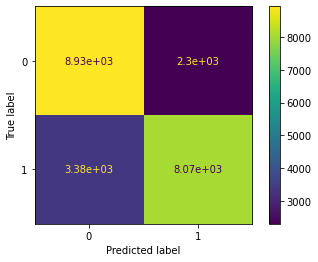

In [49]:
print(classification_report(y_test[:, 1], y_pred))
CM = confusion_matrix(y_test[:, 1], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=np.arange(10))
disp.plot( values_format ='.3g')
plt.show()

### 2. построить различные архитектуры с RNN

In [50]:
model = Sequential()

model.add(Embedding(input_dim=word_count,
                    input_length=training_length,
                    output_dim=training_length,
                    trainable=True,
                    mask_zero=True))
model.add(Masking(mask_value=0.0))

model.add(SimpleRNN(128))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 40, 40)            9376160   
                                                                 
 masking_2 (Masking)         (None, 40, 40)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 128)               21632     
                                                                 
 flatten_8 (Flatten)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 flatten_9 (Flatten)         (None, 64)               

In [52]:
early_stopping=EarlyStopping(monitor='val_loss')  

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/20
319/319 [==============================] - 117s 362ms/step - loss: 0.5566 - accuracy: 0.7105 - val_loss: 0.4774 - val_accuracy: 0.7655
Epoch 2/20
319/319 [==============================] - 110s 346ms/step - loss: 0.2959 - accuracy: 0.8787 - val_loss: 0.5373 - val_accuracy: 0.7525


In [53]:
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 3s 63ms/step - loss: 0.5513 - accuracy: 0.7467


Test score: 0.5512868762016296
Test accuracy: 0.7466825246810913


In [54]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions,axis=1)

709/709 [==============================] - 7s 9ms/step


              precision    recall  f1-score   support

         0.0       0.72      0.80      0.76     11234
         1.0       0.78      0.69      0.73     11449

    accuracy                           0.75     22683
   macro avg       0.75      0.75      0.75     22683
weighted avg       0.75      0.75      0.75     22683



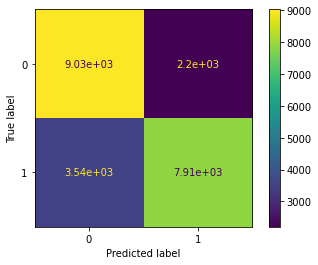

In [55]:
print(classification_report(y_test[:, 1], y_pred))
CM = confusion_matrix(y_test[:, 1], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=np.arange(10))
disp.plot( values_format ='.3g')
plt.show()

### 3. построить совместные архитектуры CNN -> RNN и/или (RNN -> CNN)


In [56]:
model = Sequential()

model.add(Embedding(input_dim=word_count,
                    input_length=training_length,
                    output_dim=training_length,
                    trainable=True,
                    mask_zero=True))

model.add(Conv1D(training_length, 3))
model.add(Activation("relu"))

model.add(Masking(mask_value=0.0))
model.add(SimpleRNN(128))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [57]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 40, 40)            9376160   
                                                                 
 conv1d_3 (Conv1D)           (None, 38, 40)            4840      
                                                                 
 activation_7 (Activation)   (None, 38, 40)            0         
                                                                 
 masking_3 (Masking)         (None, 38, 40)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 128)               21632     
                                                                 
 flatten_10 (Flatten)        (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)               

In [58]:
early_stopping=EarlyStopping(monitor='val_loss')  

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/20
319/319 [==============================] - 119s 364ms/step - loss: 0.5458 - accuracy: 0.7144 - val_loss: 0.4764 - val_accuracy: 0.7665
Epoch 2/20
319/319 [==============================] - 115s 361ms/step - loss: 0.2773 - accuracy: 0.8866 - val_loss: 0.5469 - val_accuracy: 0.7523


In [59]:
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 3s 66ms/step - loss: 0.5628 - accuracy: 0.7465


Test score: 0.5627900958061218
Test accuracy: 0.7465062141418457


In [60]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions,axis=1)

709/709 [==============================] - 7s 10ms/step


              precision    recall  f1-score   support

         0.0       0.73      0.78      0.75     11234
         1.0       0.77      0.71      0.74     11449

    accuracy                           0.75     22683
   macro avg       0.75      0.75      0.75     22683
weighted avg       0.75      0.75      0.75     22683



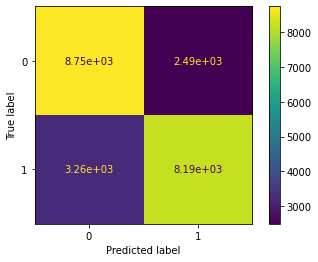

In [61]:
print(classification_report(y_test[:, 1], y_pred))
CM = confusion_matrix(y_test[:, 1], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=np.arange(10))
disp.plot( values_format ='.3g')
plt.show()

### 4. сделать выводы что получилось лучше

Все три модели показали одинаковый результат. 